In [1]:
import sys
sys.path.append("../")
from fitters import GraphDecoder

decoder = GraphDecoder(3,4)

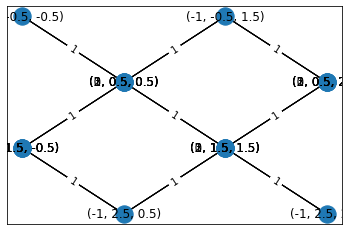

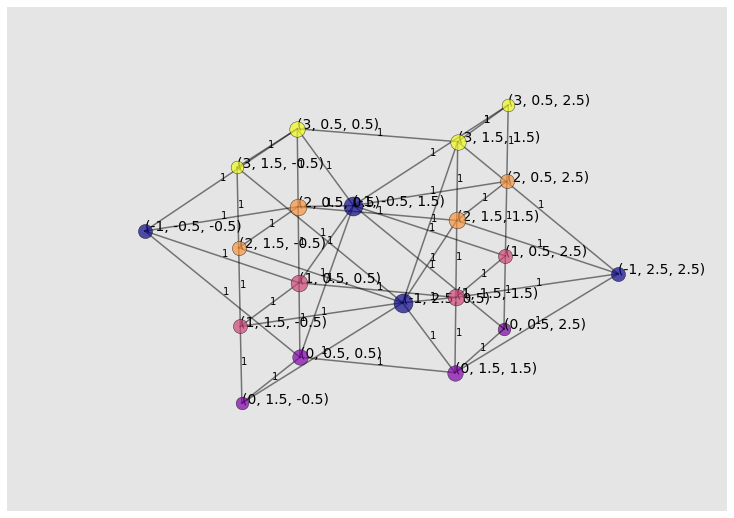

In [2]:
G = decoder.S['Z']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

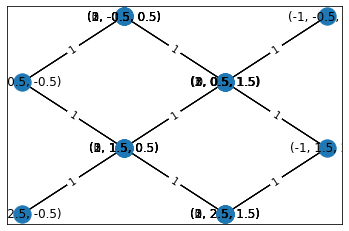

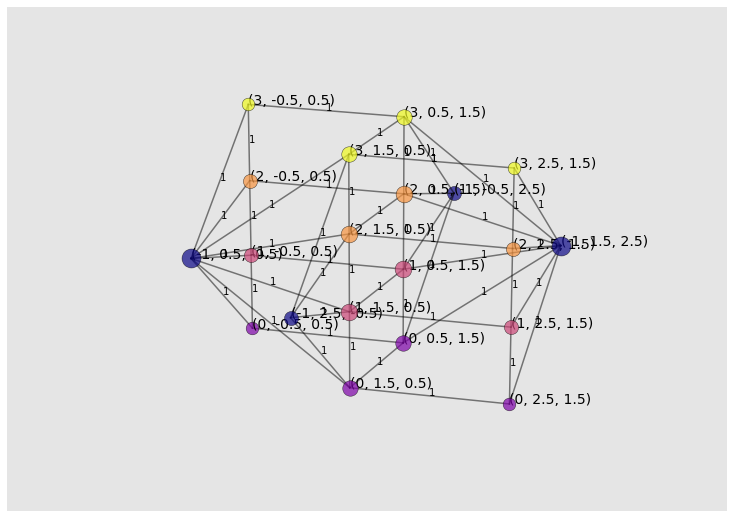

In [3]:
G = decoder.S['X']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

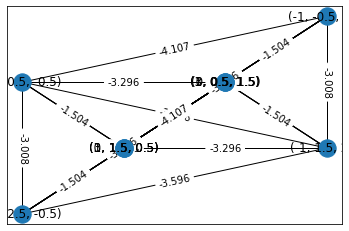

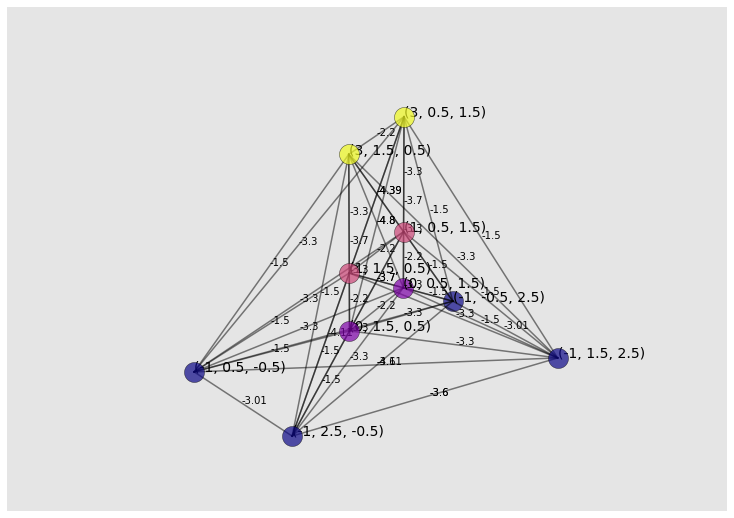

In [4]:
node_set = [(0,1.5,.5),(0,.5,1.5),(1,1.5,.5),(1,.5,1.5),(3,1.5,.5),(3,.5,1.5)]
error_graph, paths = decoder.make_error_graph(node_set,'X',err_prob=1/10)
decoder.graph_2D(error_graph,'weight')#note that some edges overlap
decoder.graph_3D(error_graph,'weight')

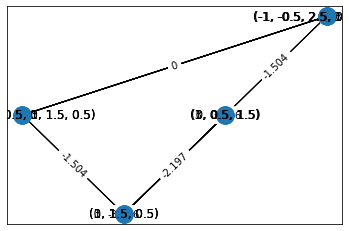

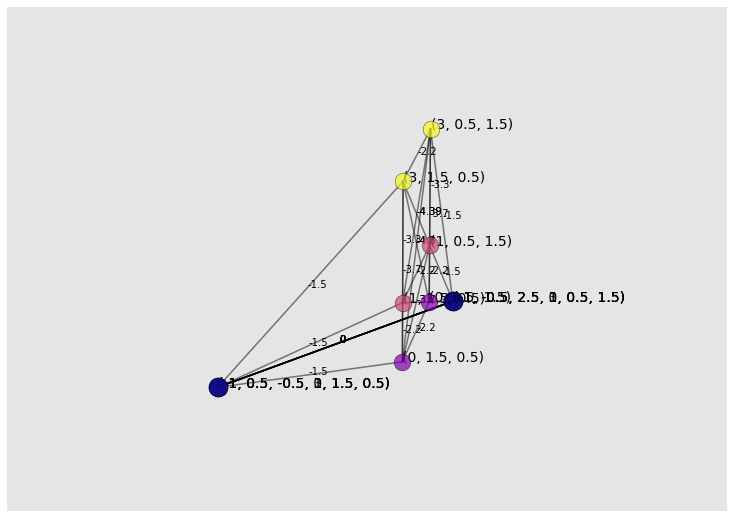

In [5]:
matching_graph = decoder.matching_graph(error_graph,'X')
decoder.graph_2D(matching_graph,'weight')
decoder.graph_3D(matching_graph,'weight')

In [6]:
matches = decoder.matching(matching_graph,'X')
for e in matches:
    print(e)

((3, 0.5, 1.5), (3, 1.5, 0.5))
((0, 1.5, 0.5), (0, 0.5, 1.5))
((1, 0.5, 1.5), (1, 1.5, 0.5))


In [7]:
flips_x = decoder.calculate_qubit_flips(matches, paths,'X')

In [8]:
node_set = [(1,.5,.5),(1,1.5,1.5)]
error_graph, paths = decoder.make_error_graph(node_set,'Z',err_prob=1/10)
matching_graph = decoder.matching_graph(error_graph,'Z')
matches = decoder.matching(matching_graph,'Z')
flips_z = decoder.calculate_qubit_flips(matches, paths,'Z')

In [9]:
decoder.net_qubit_flips(flips_x, flips_z)

Physical Qubit: (1.0, 1.0)
Error: X at time: 0
Error: Y at time: 1
Error: X at time: 3


{(1.0,
  1.0): array([[0.+0.j, 0.+1.j],
        [0.-1.j, 0.+0.j]])}

In [16]:
decoder = GraphDecoder(9,2)

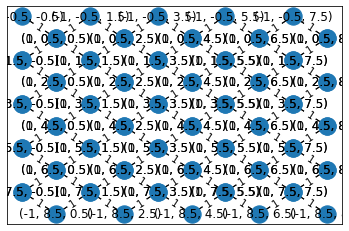

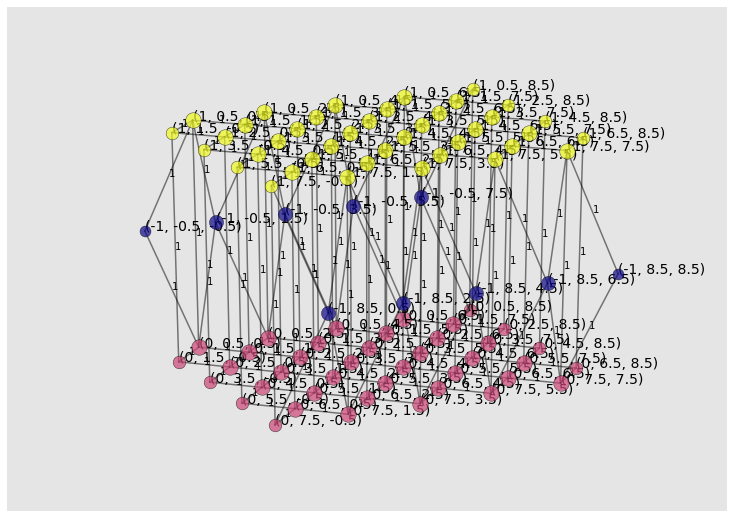

In [17]:
G = decoder.S['Z']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

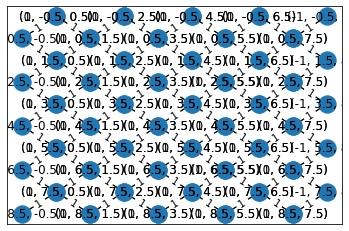

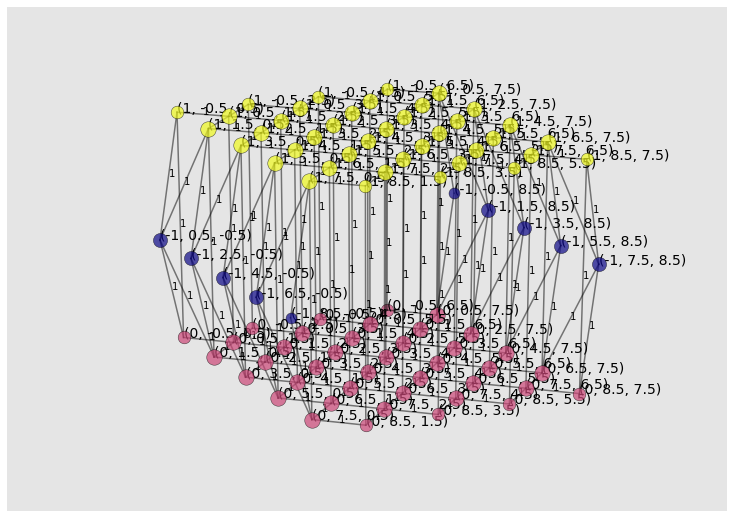

In [18]:
G = decoder.S['X']
decoder.graph_2D(G,'distance')
decoder.graph_3D(G,'distance')

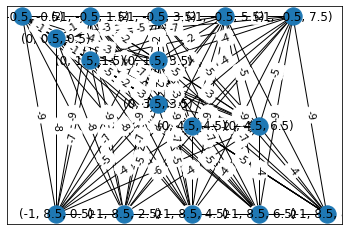

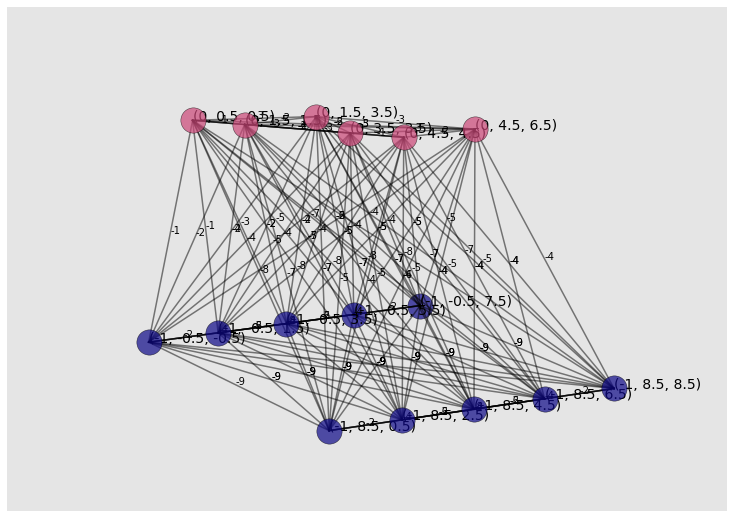

In [19]:
node_set = [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5),(0,3.5,3.5),(0,4.5,4.5),(0,4.5,6.5)]
error_graph, paths = decoder.make_error_graph(node_set,'Z')
decoder.graph_2D(error_graph,'weight')#note that some edges overlap
decoder.graph_3D(error_graph,'weight')#note that some edges overlap

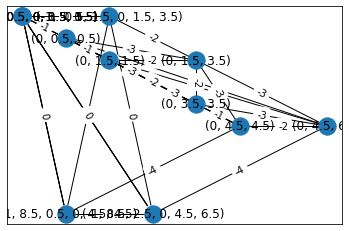

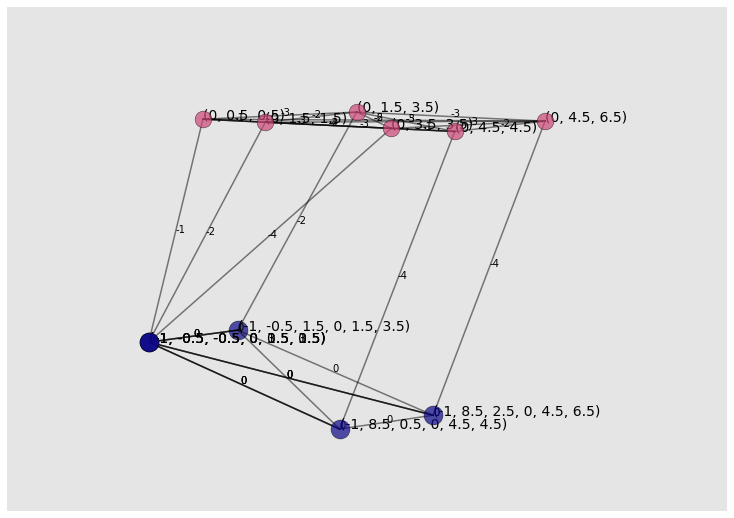

In [20]:
matching_graph = decoder.matching_graph(error_graph,'Z')
decoder.graph_2D(matching_graph,'weight')
decoder.graph_3D(matching_graph,'weight')

In [21]:
g = decoder.matching(matching_graph,'Z')
for e in g:
    print(e)

((0, 1.5, 1.5), (0, 0.5, 0.5))
((0, 3.5, 3.5), (0, 4.5, 4.5))
((0, 4.5, 6.5), (0, 1.5, 3.5))


In [22]:
matching_graph = decoder.matching_graph(error_graph,'Z')
matches = decoder.matching(matching_graph,'Z')
flips_z = decoder.calculate_qubit_flips(matches, paths,'Z')

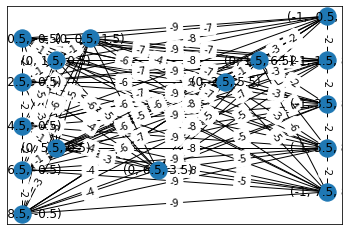

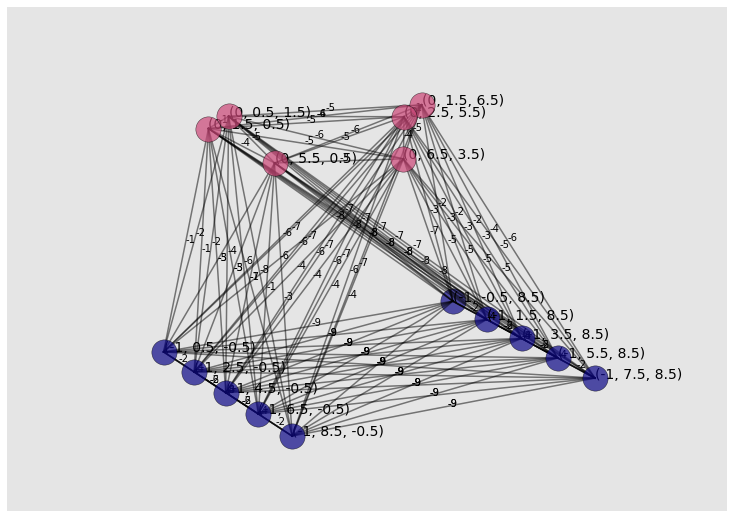

In [23]:
node_set = [(0,1.5,0.5),(0,0.5,1.5),(0,1.5,6.5),(0,2.5,5.5),(0,5.5,.5),(0,6.5,3.5)]
error_graph, paths = decoder.make_error_graph(node_set,'X')
decoder.graph_2D(error_graph,'weight')#note that some edges overlap
decoder.graph_3D(error_graph,'weight')

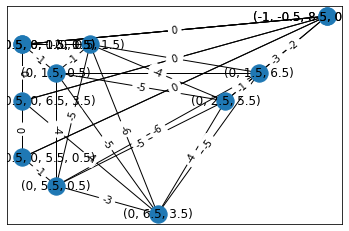

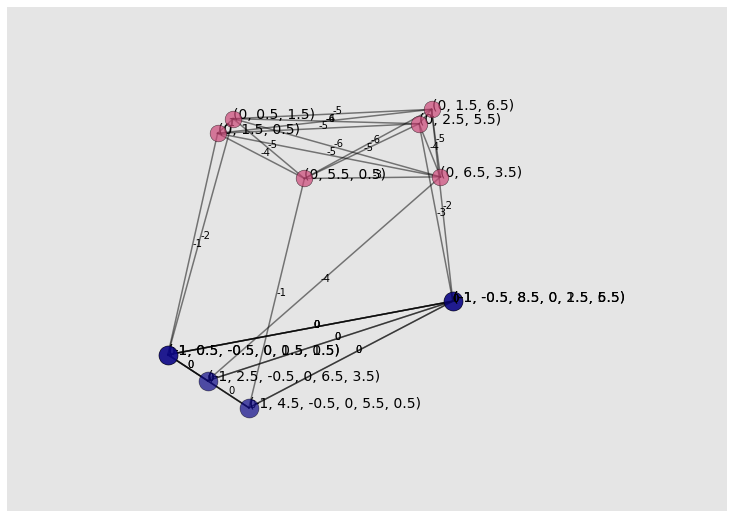

In [24]:
matching_graph = decoder.matching_graph(error_graph,'X')
decoder.graph_2D(matching_graph,'weight')
decoder.graph_3D(matching_graph,'weight')

In [16]:
g = decoder.matching(matching_graph,'X')
for e in g:
    print(e)

((0, 6.5, 3.5), (0, 5.5, 0.5))
((0, 1.5, 6.5), (0, 2.5, 5.5))
((0, 1.5, 0.5), (0, 0.5, 1.5))


In [25]:
matching_graph = decoder.matching_graph(error_graph,'X')
matches = decoder.matching(matching_graph,'X')
flips_x = decoder.calculate_qubit_flips(matches, paths,'X')

In [26]:
decoder.net_qubit_flips(flips_x, flips_z)

Physical Qubit: (2.0, 6.0)
Error: X at time: 0
Physical Qubit: (5.0, 1.0)
Error: X at time: 0
Physical Qubit: (5.0, 2.0)
Error: X at time: 0
Physical Qubit: (6.0, 3.0)
Error: X at time: 0
Physical Qubit: (1.0, 1.0)
Error: Y at time: 0
Physical Qubit: (4.0, 4.0)
Error: Z at time: 0
Physical Qubit: (2.0, 4.0)
Error: Z at time: 0
Physical Qubit: (3.0, 5.0)
Error: Z at time: 0
Physical Qubit: (4.0, 6.0)
Error: Z at time: 0


{(2.0,
  6.0): array([[0, 1],
        [1, 0]]),
 (5.0,
  1.0): array([[0, 1],
        [1, 0]]),
 (5.0,
  2.0): array([[0, 1],
        [1, 0]]),
 (6.0,
  3.0): array([[0, 1],
        [1, 0]]),
 (1.0,
  1.0): array([[0.+0.j, 0.-1.j],
        [0.+1.j, 0.+0.j]]),
 (4.0,
  4.0): array([[ 1,  0],
        [ 0, -1]]),
 (2.0,
  4.0): array([[ 1,  0],
        [ 0, -1]]),
 (3.0,
  5.0): array([[ 1,  0],
        [ 0, -1]]),
 (4.0,
  6.0): array([[ 1,  0],
        [ 0, -1]])}